<a href="https://colab.research.google.com/github/avkornaev/Python-for-image-processing-course/blob/main/Cells_counter_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The algorithm is based on the watershed method. If you want to know more, please check the following links: https://imagej.net/plugins/classic-watershed,
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

Install libraries. Execute code bellow just once to install the libraries. Then you may comment 'pip' lines using # in the begining of lines of the code.

In [494]:
!pip install czifile
!pip install tifffile
!pip install imagecodecs

Connect to Google disk.

In [495]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries.

In [496]:
import cv2
import numpy as np
#from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io, img_as_ubyte, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import clear_border
import czifile
import imagecodecs
#import tifffile

Check the settings.

In [497]:
img_size = (30,30)
img_map = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)
img_path = '/content/drive/MyDrive/Cells_count/'
img_title = 'B16_1122_2_2.czi'

kernel = np.ones((5,5),np.uint8)
kernel4filt = (5,5)
numberOfIter = 2 #number of iterations
dist_transf_ratio = 0.1 # distance transform ratio
markers_bias = 300
pixels2microns = 0.396 #scale factor

Download "czi" image and create slices of the image.

In [498]:
img = czifile.imread(img_path + img_title)

img_slice = img[0,0,0,:,0,1:512,1:512,0]# image in a form of 3D matrix
#img_slice = np.concatenate((img_slice, img_slice[0,:,:]), axis=1)
#img_slice[2,:,:] = img_slice[0,:,:]
img0 = img_slice[0,:,:] # 0 channel that is fluo4-T1 (highlights the apoptosis cells)
img1 = img_slice[1,:,:] # 1 channel that is H3342-T2 (highlights all the cells)

print('CZI image shape: ',img.shape)# ?, ?, ?, number of chanels, x size, y size, ?
print('2 channels shape: ',img_slice.shape)
print('0 channel shape: ',img0.shape)
print('1 channel shape: ',img1.shape)

CZI image shape:  (1, 1, 1, 2, 1, 3277, 3277, 1)
2 channels shape:  (2, 511, 511)
0 channel shape:  (511, 511)
1 channel shape:  (511, 511)


Filter image slices

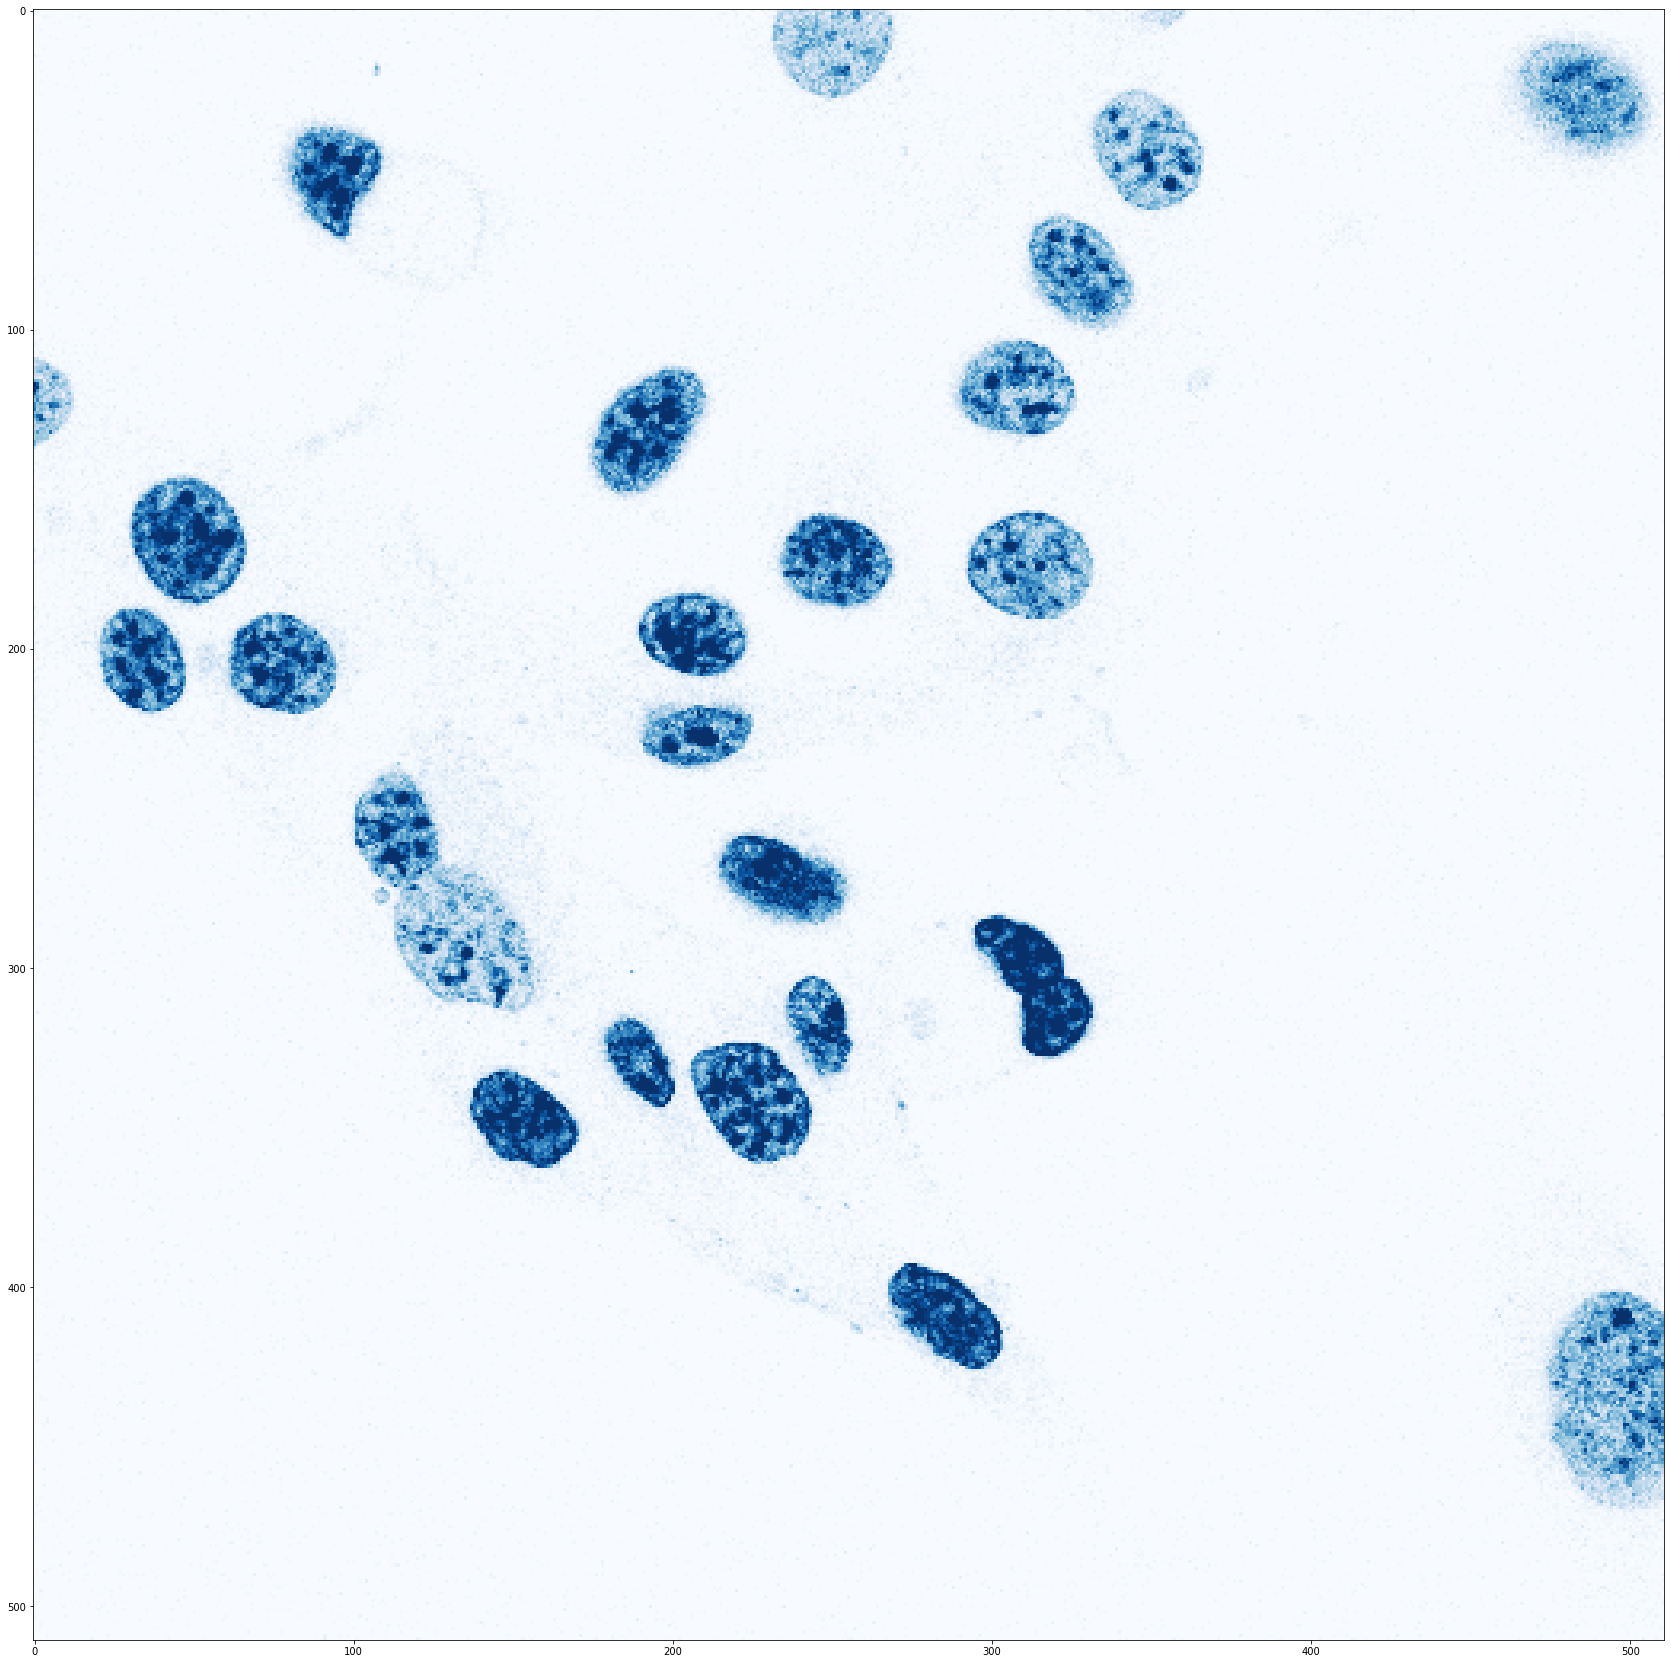

In [499]:
plt.figure(figsize=img_size)
plt.imshow(img1,cmap=img_map)

In [500]:
#img0 = cv2.GaussianBlur(img0,kernel4filt,0) # Gaussian blur
#img1 = cv2.GaussianBlur(img1,kernel4filt,0)

print('1 channel shape: ',img1.shape, img1.dtype, type(img1))
sigma_est = np.mean(estimate_sigma(img1, multichannel=False))
patch_kw = dict(patch_size=5,      
                patch_distance=3,  
                multichannel=False)
img1 = denoise_nl_means(img1, h=115 * sigma_est, fast_mode=False, **patch_kw)
img1 = np.uint16(img1)
img1= ndimage.median_filter(img1, size=5)
#img1 = img_slice[1,:,:]
print('1 channel shape: ',img1.shape, img1.dtype, type(img1))
#img1edges = cv2.Canny(np.uint16(img1),0.1,0.1)

1 channel shape:  (511, 511) uint16 <class 'numpy.ndarray'>
1 channel shape:  (511, 511) uint16 <class 'numpy.ndarray'>


Visualize image and its slices

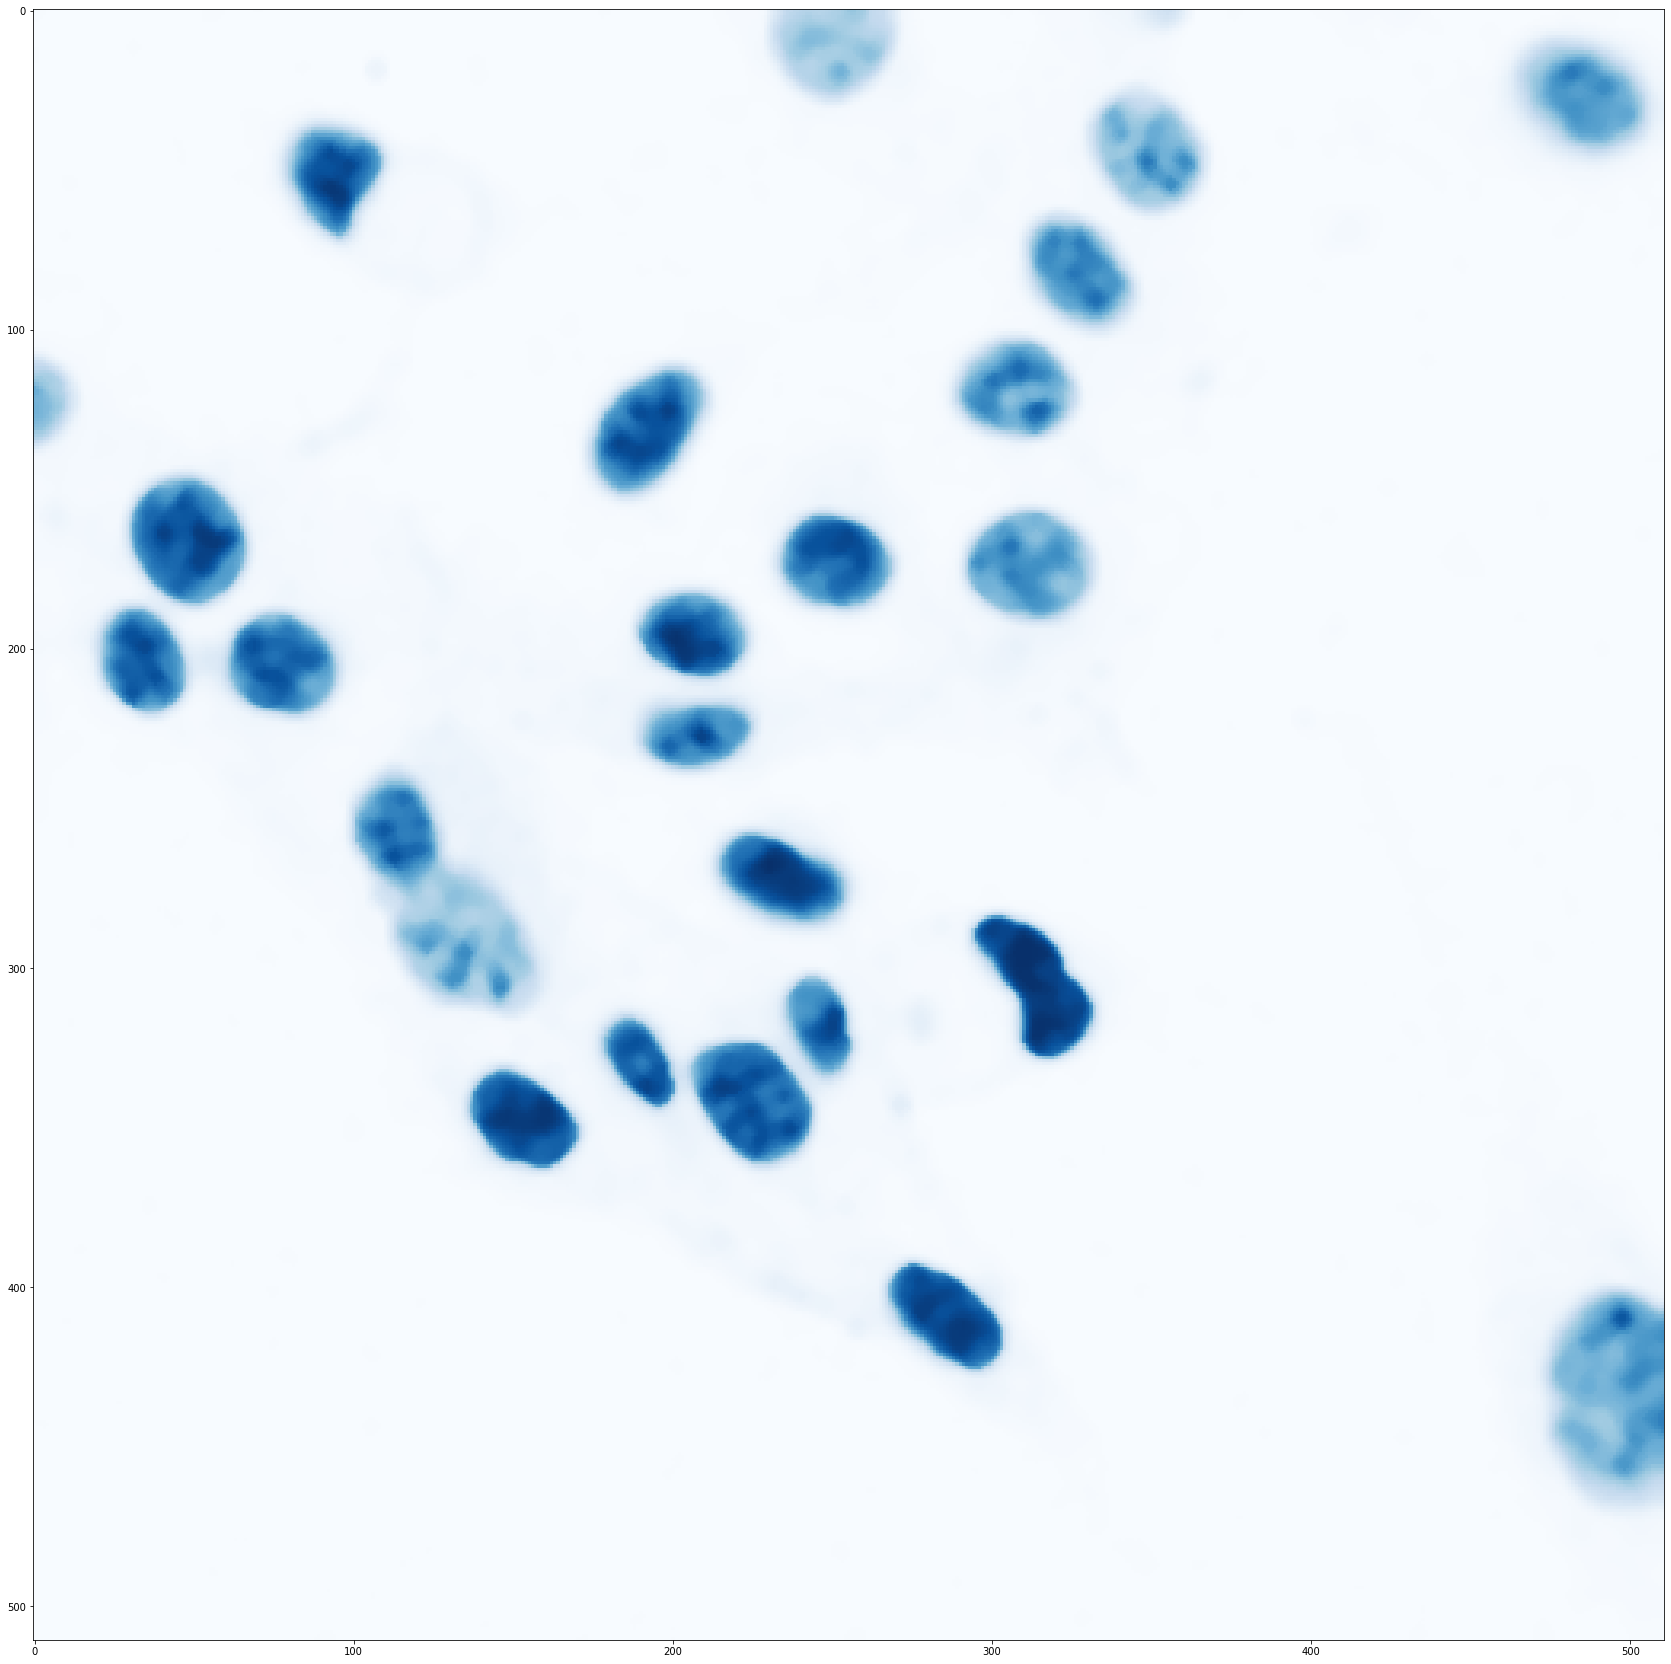

In [501]:
plt.figure(figsize=img_size)
plt.imshow(img1,cmap=img_map)

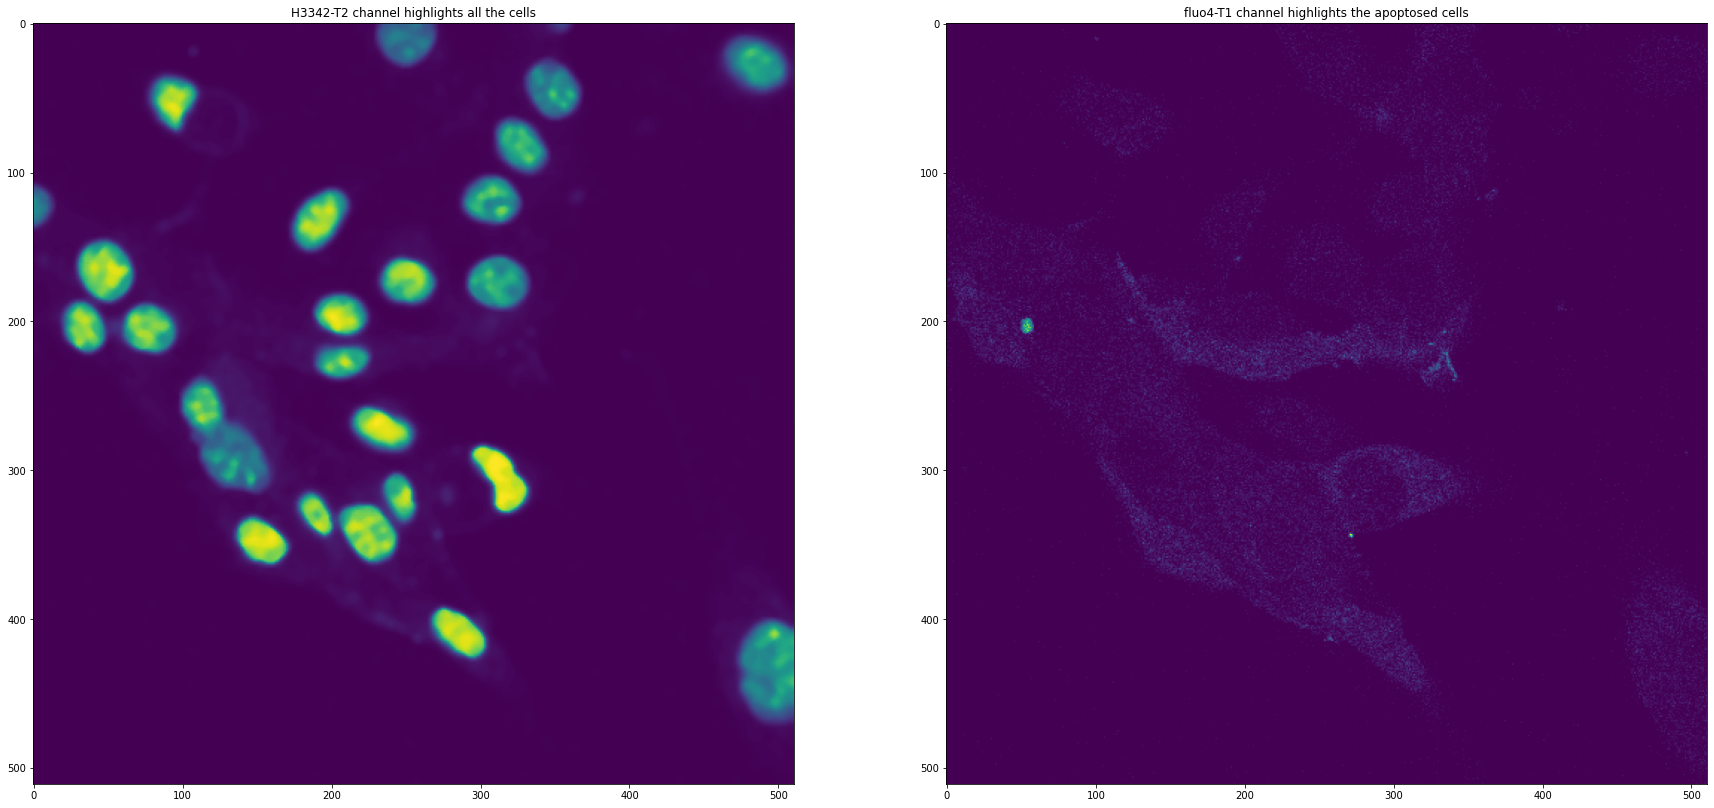

In [502]:
plt.figure(figsize=(img_size[0],img_size[1]/2))
plt.subplot(1,2,1)
plt.title('H3342-T2 channel highlights all the cells')
plt.imshow(img1)

plt.subplot(1,2,2)
plt.title('fluo4-T1 channel highlights the apoptosed cells')
plt.imshow(img0)

Create tepmorary files.

In [503]:
img_path_temp0 = img_path + img_title[0:-4] + '_ch0.tiff' # path 0
img_path_temp1 = img_path + img_title[0:-4] + '_ch1.tiff' # path 1
cv2.imwrite(img_path_temp0, img0) # save img0 in tiff file (temporary file)
cv2.imwrite(img_path_temp1, img1) # save img1 in tiff file (temporary file)
img_path_temp1

'/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch1.tiff'

Read image using OpenCV.

In [504]:
img1gray = cv2.imread(img_path_temp1,cv2.IMREAD_GRAYSCALE)
#cv2_imshow(img1temp)
print(type(img1gray),img1gray.shape,img1gray.dtype)

<class 'numpy.ndarray'> (511, 511) uint8


Threshold image to binary using OTSU. ALl thresholded pixels are set to 255. Then remove noise (opening) and remove edge touching with clear_border function.

In [505]:
ret1, thresh1 = cv2.threshold(img1gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
opening1 = cv2.morphologyEx(thresh1,cv2.MORPH_OPEN,kernel, iterations = numberOfIter)
opening1 = clear_border(opening1)
#cv2_imshow(opening1)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=1)
#cv2.imshow('Opening Image', thresh)

Identify background and foreground area (OpenCV - Distance Transformation)

In [506]:
sure_bg1 = cv2.dilate(opening1,kernel,iterations=numberOfIter)
#cv2_imshow(sure_bg1) # sure background

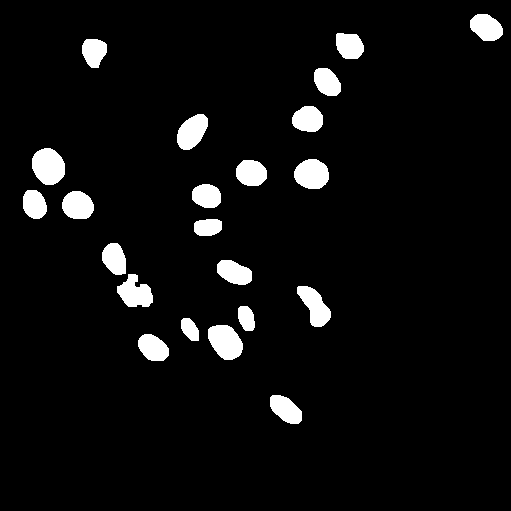

In [507]:
dist_transform1 = cv2.distanceTransform(opening1,cv2.DIST_L2,5)
ret12, sure_fg1 = cv2.threshold(dist_transform1, dist_transf_ratio*dist_transform1.max(), 255,0)
sure_fg1 = np.uint8(sure_fg1)
cv2_imshow(sure_fg1) # sure foreground

<class 'numpy.ndarray'> (511, 511) uint8
<class 'numpy.ndarray'> (511, 511) int32


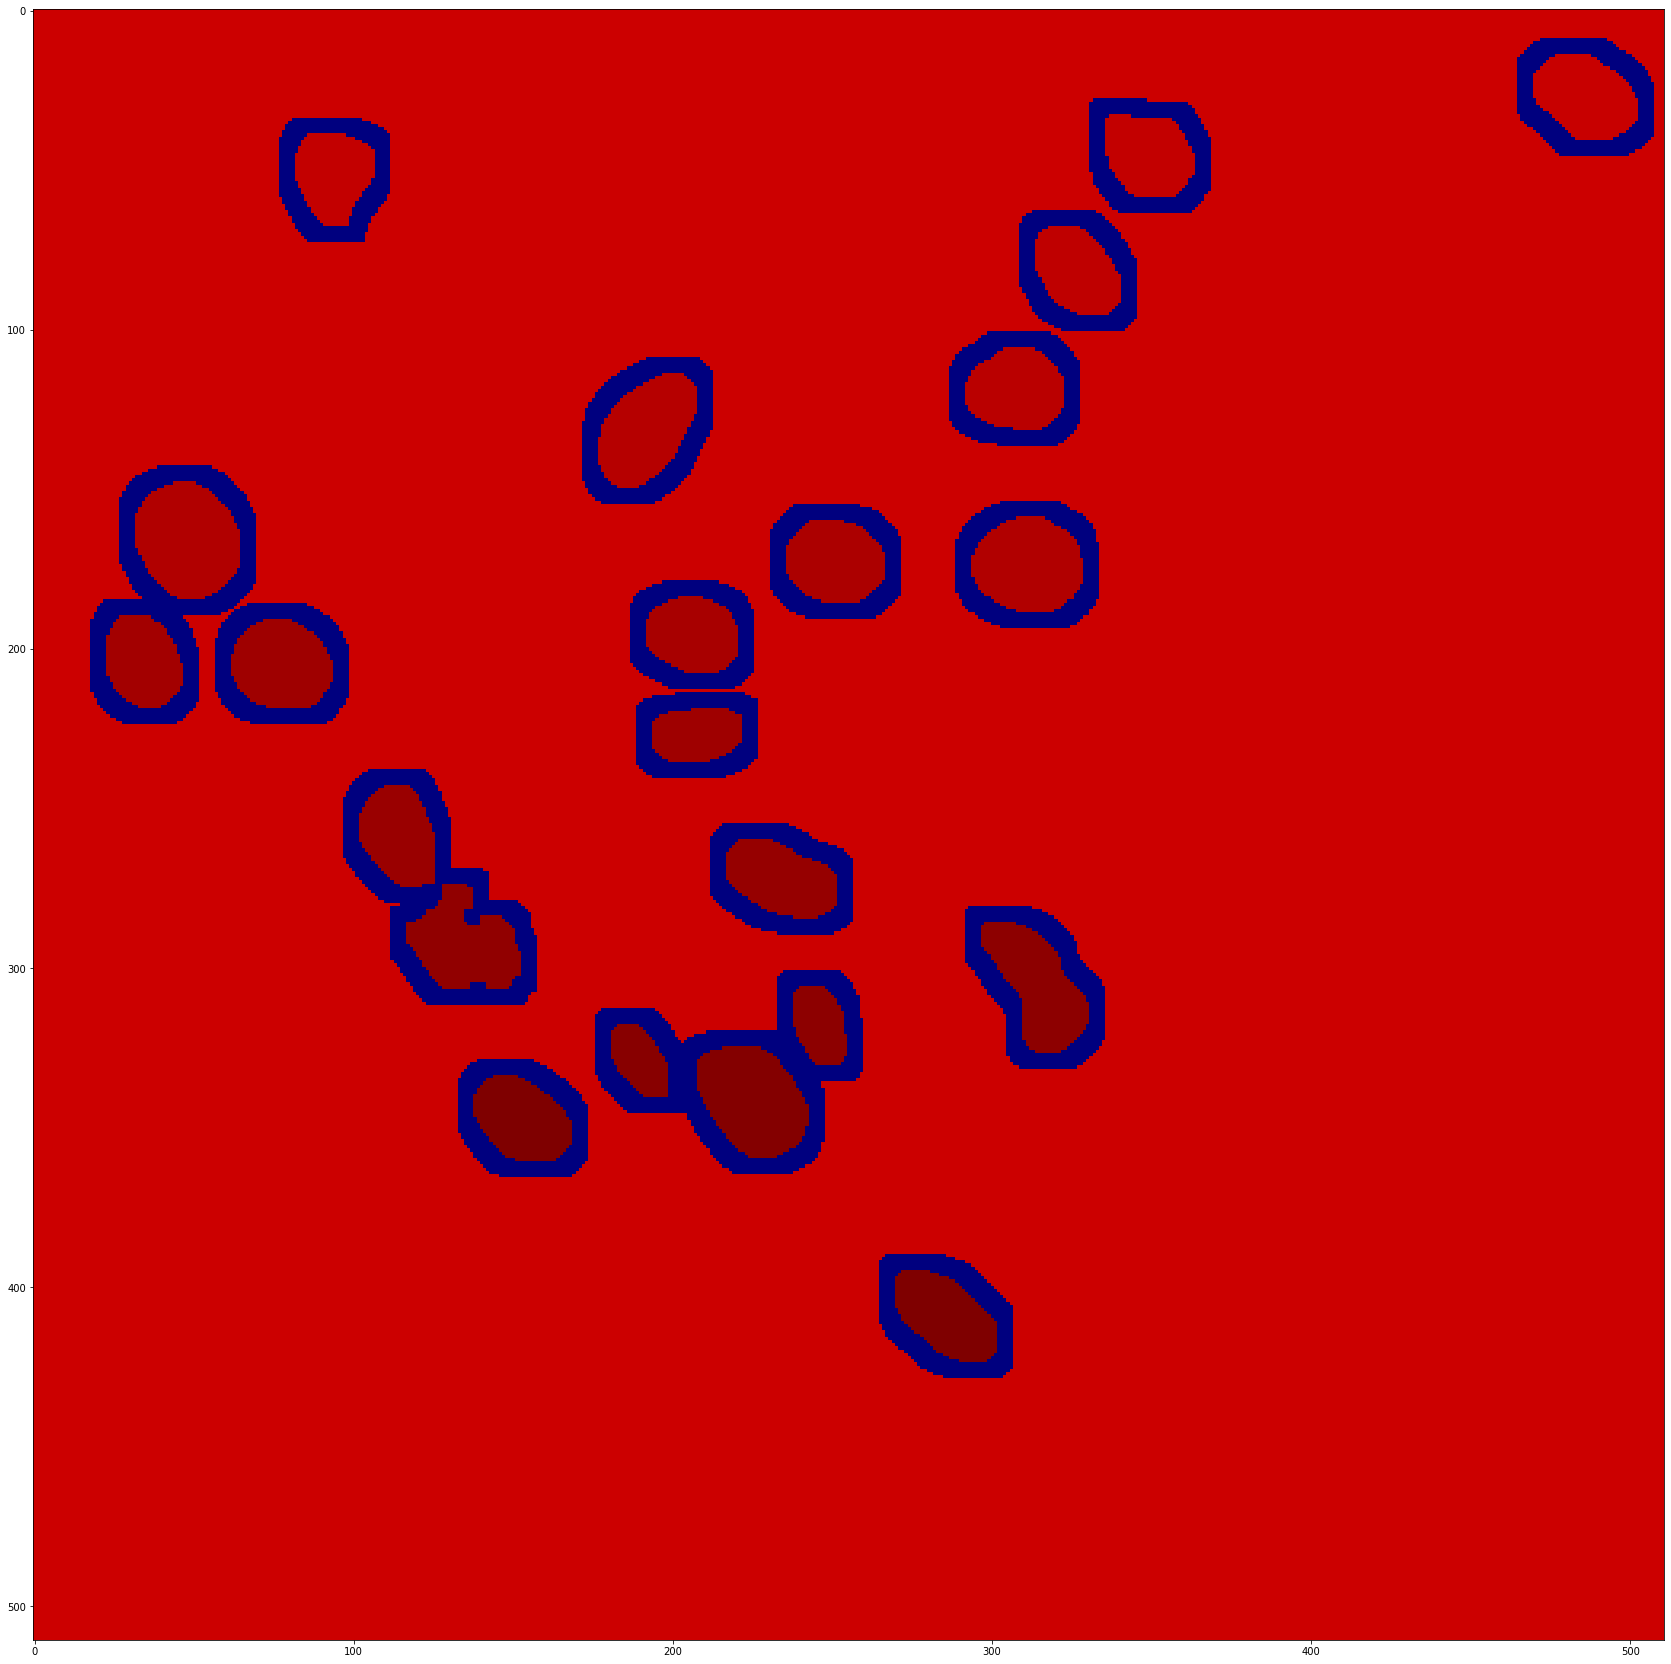

In [508]:
unknown1 = cv2.subtract(sure_bg1, sure_fg1)
ret13, markers1 = cv2.connectedComponents(sure_fg1)
markers1 = markers1 + markers_bias

markers1[unknown1==255] = 0
#markers1 = np.uint8(markers1)
#cv2_imshow(unknown)
plt.figure(figsize=img_size)
plt.imshow(markers1, cmap='jet')
print(type(sure_fg1),sure_fg1.shape,sure_fg1.dtype)
print(type(markers1),markers1.shape,markers1.dtype)

In [509]:
#markers1 = np.uint8(markers1)
#img1 = np.uint8(img1)
#print(type(markers1),markers1.shape,markers1.dtype)
#print(type(img1),img1.shape,img1.dtype)
markers1 = cv2.watershed(cv2.imread(img_path_temp1),markers1) #The boundary region will be marked -1


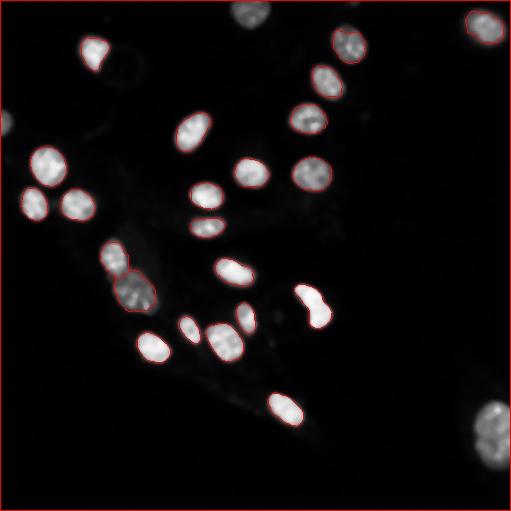

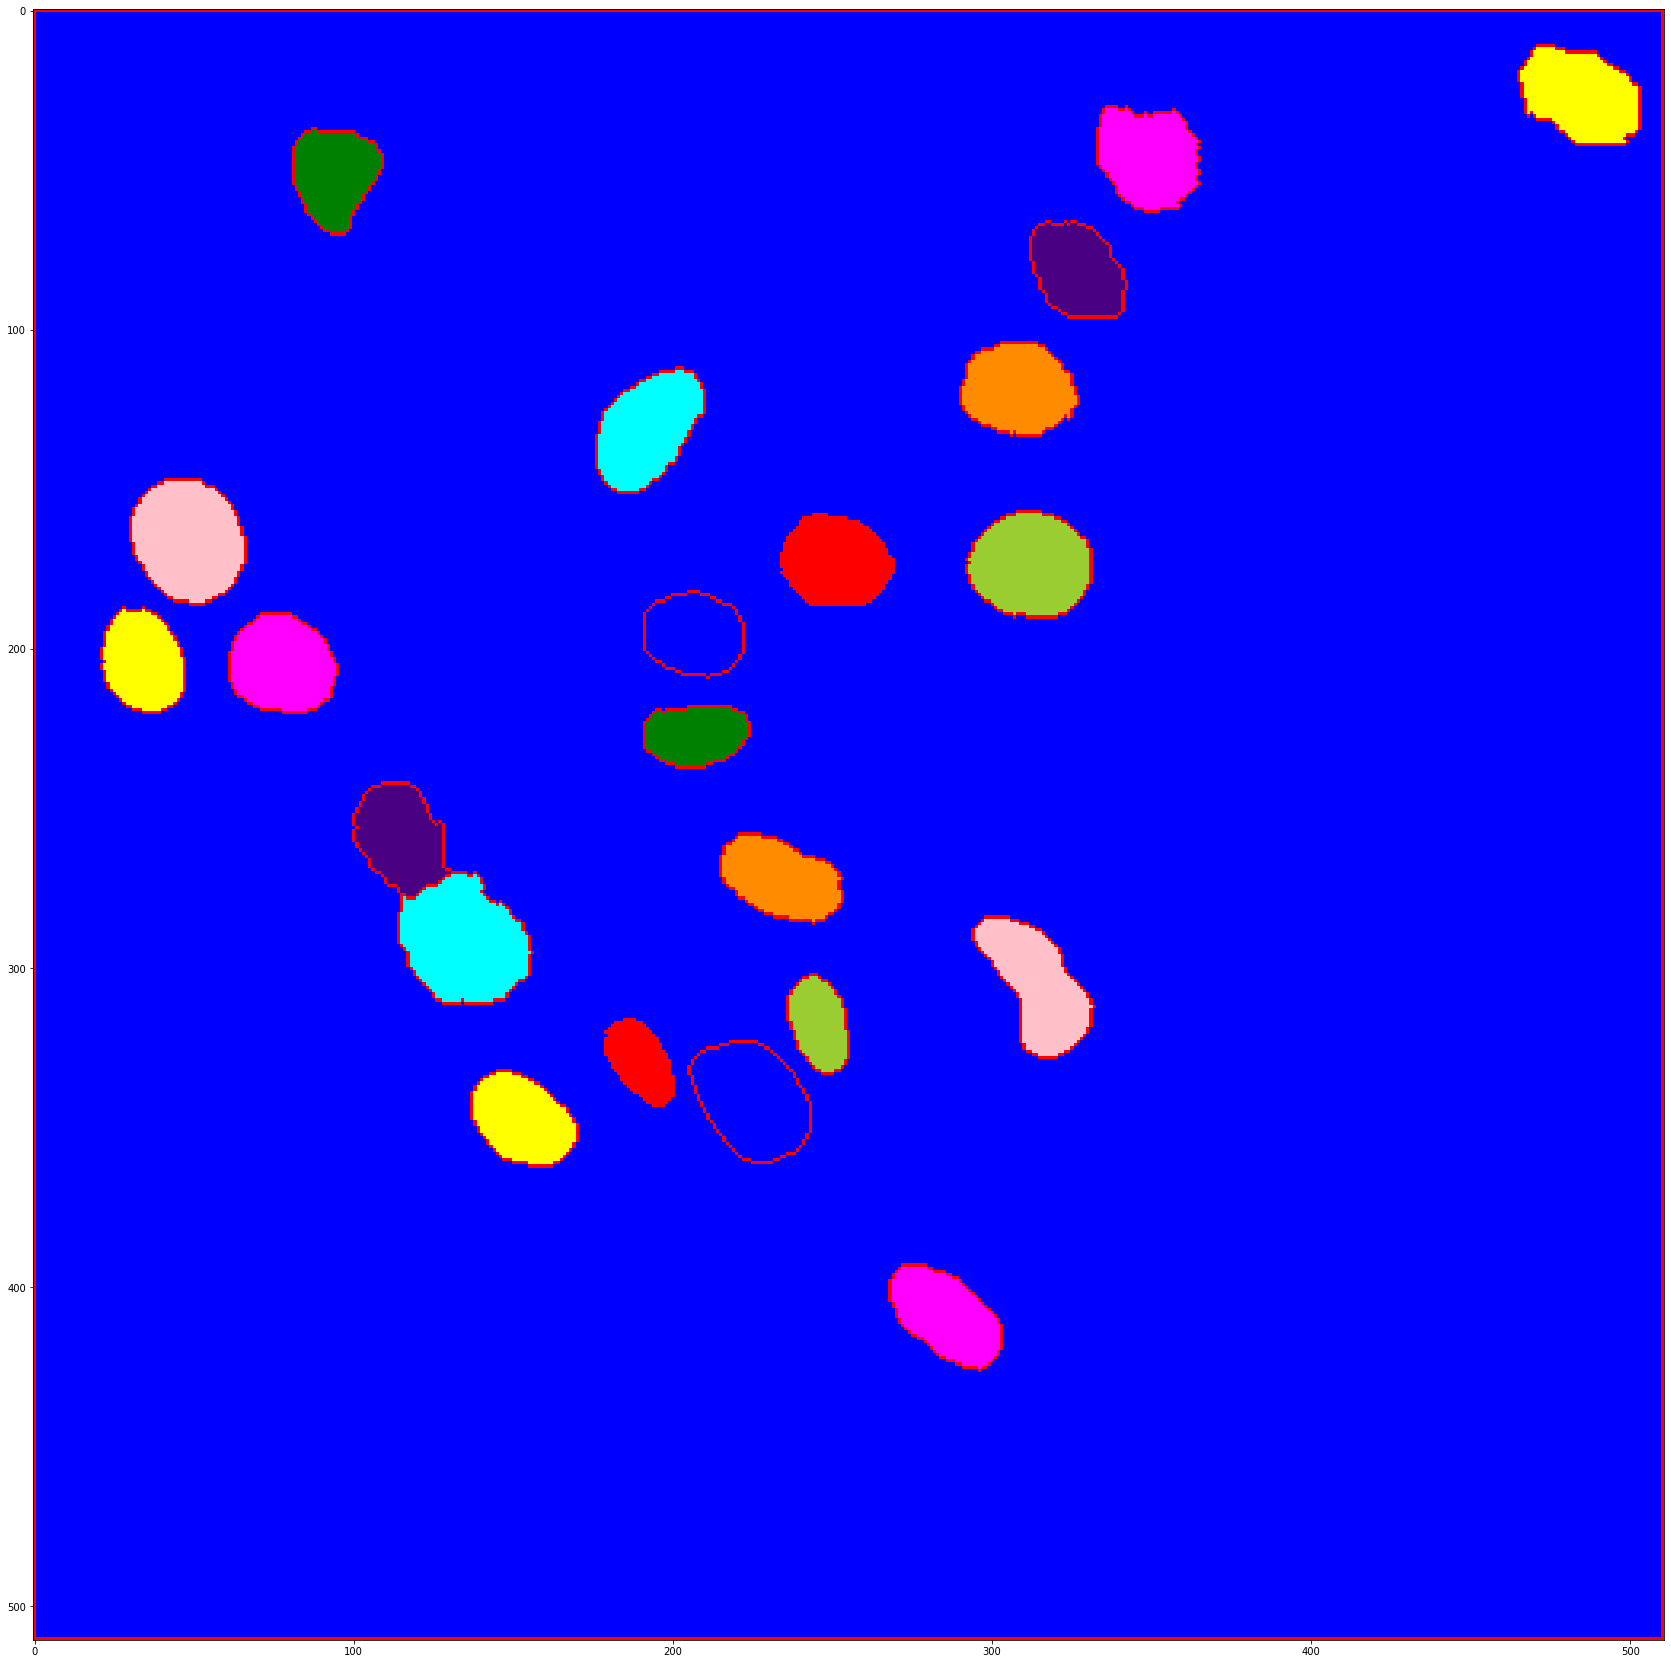

In [510]:
imgC = cv2.imread(img_path_temp1)
imgC[markers1 == -1] = [0,0,255]
imgC2 = color.label2rgb(markers1, bg_label=0)
#cv2_imshow(markers1)
cv2_imshow(imgC)
#cv2_imshow(imgC2,)
plt.figure(figsize=img_size)
plt.imshow(imgC2, cmap='jet')

Calculate metrics.

In [515]:
regions = measure.regionprops(markers1, intensity_image=img1)
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']
output_file = open('image_measurements.csv', 'w')
output_file.write('Grain #' + "," + "," + ",".join(propList) + '\n') #join strings in array by commas, 

#First cell to print grain number
#Second cell blank as we will not print Label column

grain_number = 1
for region_props in regions:
    output_file.write(str(grain_number) + ',')
    #output cluster properties to the excel file
#    output_file.write(str(region_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels2microns**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels2microns
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
    grain_number += 1
output_file.close()   #Closes the file, otherwise it would be read only. 
print('Number of grains',grain_number)

Number of grains 24


In [511]:
#img4 = cv2.imread('/content/drive/MyDrive/Cells_count/B16_1122_2_2.czi')
#img_RGB = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#cv2.imshow('Color picture from opencv',img4)
#edges = cv2.Canny(img3, 100, 200)
#print(img3.shape)